In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import cv2
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import sys
import time
from PIL import Image

In [2]:
torch.manual_seed(1220)
random.seed(1220)
np.random.seed(1220)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

path_dataset = "./full_crack_type"

You are using device: cuda


In [4]:
def load_dataset(path_dataset):
    imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop((400, 400)),  
        transforms.CenterCrop((350, 350)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        # transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
    ])

    val_transform = transforms.Compose([
        transforms.CenterCrop((400, 400)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
    ])

    full_dataset = torchvision.datasets.ImageFolder(root=path_dataset)
    classes = full_dataset.classes
    print(classes)
    dataset_size = len(full_dataset)
    train_size = int(0.85 * dataset_size)
    val_size = dataset_size - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True, num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=32, shuffle=False, num_workers=4
    )

    return train_loader, val_loader, classes

train_loader, val_loader, classes = load_dataset(path_dataset)

# model_ = torchvision.models.resnet50(weights='IMAGENET1K_V2')
# model_.fc = nn.Sequential(
#     nn.Linear(model_.fc.in_features, len(classes)),
#     nn.Sigmoid()
# )

model_ = torchvision.models.shufflenet_v2_x1_5(weights='IMAGENET1K_V1')
model_.fc = nn.Sequential(
    nn.Linear(model_.fc.in_features, len(classes)),
    nn.Sigmoid()
)

['Diagonal', 'Horizontal', 'Vertical', 'Web', 'X-shape']


In [ ]:
if torch.cuda.is_available():
    model_.cuda()
from torchsummary import summary
summary(model_, (3, 400, 400))
print(model_)

In [6]:
def train(model, trainloader, valloader, epochs=10):
    torch.cuda.empty_cache()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-7)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=32)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 80
    best_val_loss = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Wrap trainloader with tqdm for progress bar to make it looks nicer
        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)
        for i, data in loop:
            # Get inputs and labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update running loss
            running_loss += loss.item()
            
            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)
        
        
        # Calculate epoch statistics for training
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Calculate validation loss
                val_running_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate epoch statistics for validation
        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_val_loss = epoch_val_loss
            torch.save(model_.state_dict(), 'model.pth')
            print(best_val_acc, best_val_loss)
        elif epoch_val_acc == best_val_acc:
            if epoch_val_loss < best_val_loss:
                torch.save(model_.state_dict(), 'model.pth')
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)
    
    print('Finished Training')
    
    return model, train_losses, train_accuracies, val_losses, val_accuracies

def evaluate(model, valloader):

    model.eval()
    correct = 0
    total = 0
    
    # Initialize lists for per-class accuracy
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    # Initialize confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for data in tqdm(valloader, desc="Evaluating"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
                # Update confusion matrix
                confusion_matrix[label, predicted[i]] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

    
    return class_correct, class_total, confusion_matrix

In [7]:
print("Starting training...")
# model_.load_state_dict(torch.load('model.pth', map_location=device))
# for param in model_.parameters():
#     param.requires_grad = True
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model_, train_loader, val_loader, epochs=15
)

Starting training...


Epoch [1/15]: 100%|██████████| 28/28 [04:43<00:00, 10.11s/it, accuracy=40, loss=1.99]  


Epoch 1/15
Train Loss: 1.9868, Train Acc: 39.95%
Val Loss: 1.9762, Val Acc: 34.62%
------------------------------------------------------------


Epoch [2/15]: 100%|██████████| 28/28 [04:45<00:00, 10.20s/it, accuracy=47.2, loss=1.9] 


Epoch 2/15
Train Loss: 1.9023, Train Acc: 47.22%
Val Loss: 1.8818, Val Acc: 45.51%
------------------------------------------------------------


Epoch [3/15]: 100%|██████████| 28/28 [04:42<00:00, 10.09s/it, accuracy=57.5, loss=1.74]


Epoch 3/15
Train Loss: 1.7424, Train Acc: 57.55%
Val Loss: 1.7106, Val Acc: 51.28%
------------------------------------------------------------


Epoch [4/15]: 100%|██████████| 28/28 [04:42<00:00, 10.11s/it, accuracy=59.3, loss=1.67]


Epoch 4/15
Train Loss: 1.6662, Train Acc: 59.25%
Val Loss: 1.7042, Val Acc: 50.00%
------------------------------------------------------------


Epoch [5/15]: 100%|██████████| 28/28 [04:41<00:00, 10.04s/it, accuracy=59.7, loss=1.63]


Epoch 5/15
Train Loss: 1.6339, Train Acc: 59.70%
Val Loss: 1.6768, Val Acc: 51.28%
------------------------------------------------------------


Epoch [6/15]: 100%|██████████| 28/28 [04:40<00:00, 10.02s/it, accuracy=62.8, loss=1.59]


Epoch 6/15
Train Loss: 1.5889, Train Acc: 62.77%
Val Loss: 1.6551, Val Acc: 51.28%
------------------------------------------------------------


Epoch [7/15]: 100%|██████████| 28/28 [04:40<00:00, 10.02s/it, accuracy=64.5, loss=1.58]


Epoch 7/15
Train Loss: 1.5763, Train Acc: 64.47%
Val Loss: 1.6547, Val Acc: 54.49%
------------------------------------------------------------


Epoch [8/15]: 100%|██████████| 28/28 [04:42<00:00, 10.08s/it, accuracy=67.7, loss=1.54]


Epoch 8/15
Train Loss: 1.5418, Train Acc: 67.65%
Val Loss: 1.6262, Val Acc: 54.49%
------------------------------------------------------------


Epoch [9/15]: 100%|██████████| 28/28 [04:40<00:00, 10.01s/it, accuracy=69.9, loss=1.51]


Epoch 9/15
Train Loss: 1.5137, Train Acc: 69.92%
Val Loss: 1.6175, Val Acc: 58.33%
------------------------------------------------------------


Epoch [10/15]: 100%|██████████| 28/28 [04:39<00:00, 10.00s/it, accuracy=70.8, loss=1.5] 


Epoch 10/15
Train Loss: 1.5001, Train Acc: 70.83%
Val Loss: 1.6277, Val Acc: 53.85%
------------------------------------------------------------


Epoch [11/15]: 100%|██████████| 28/28 [04:39<00:00,  9.98s/it, accuracy=74.3, loss=1.47]


Epoch 11/15
Train Loss: 1.4698, Train Acc: 74.35%
Val Loss: 1.6079, Val Acc: 56.41%
------------------------------------------------------------


Epoch [12/15]: 100%|██████████| 28/28 [04:40<00:00, 10.01s/it, accuracy=74.6, loss=1.47]


Epoch 12/15
Train Loss: 1.4682, Train Acc: 74.57%
Val Loss: 1.6023, Val Acc: 57.69%
------------------------------------------------------------


Epoch [13/15]: 100%|██████████| 28/28 [04:38<00:00,  9.94s/it, accuracy=77.4, loss=1.45]


Epoch 13/15
Train Loss: 1.4512, Train Acc: 77.41%
Val Loss: 1.5806, Val Acc: 60.26%
------------------------------------------------------------


Epoch [14/15]: 100%|██████████| 28/28 [04:39<00:00,  9.97s/it, accuracy=78.5, loss=1.43]


Epoch 14/15
Train Loss: 1.4350, Train Acc: 78.55%
Val Loss: 1.6199, Val Acc: 55.13%
------------------------------------------------------------


Epoch [15/15]: 100%|██████████| 28/28 [04:40<00:00, 10.01s/it, accuracy=78.2, loss=1.42]


Epoch 15/15
Train Loss: 1.4210, Train Acc: 78.21%
Val Loss: 1.5716, Val Acc: 60.26%
------------------------------------------------------------
Finished Training


#### Evaluating

In [8]:
print("Starting evaluating...")
class_correct, class_total, confusion_matrix = evaluate(trained_model, val_loader)

Starting evaluating...


Evaluating: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

Overall Accuracy: 60.26%


#### Plot function

In [9]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig('training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

In [10]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    num_classes = len(classes)
    
    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []
    
    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')
    
    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('per_class_accuracy.png')
    plt.show()
    
    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
   
    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{normalized_confusion_matrix[i, j]:.2f}',
                     horizontalalignment="center",
                     color="white" if normalized_confusion_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return

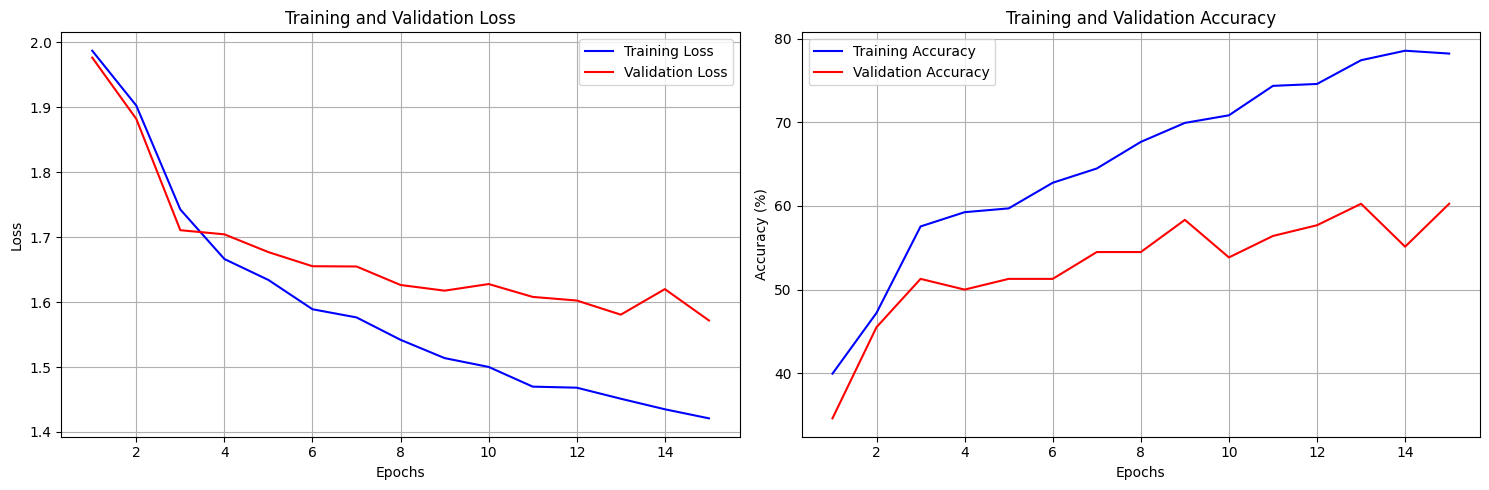

Training metrics plot saved as 'training_metrics.png'


In [11]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)


Per-class Accuracy:
--------------------------------------------------
Diagonal: 66.67% (16/24)
Diagonal_small: 61.54% (8/13)
Horizontal: 81.48% (22/27)
Horizontal_small: 38.10% (8/21)
Vertical: 86.36% (19/22)
Vertical_small: 0.00% (0/12)
Web: 65.52% (19/29)
X-shape: 25.00% (2/8)


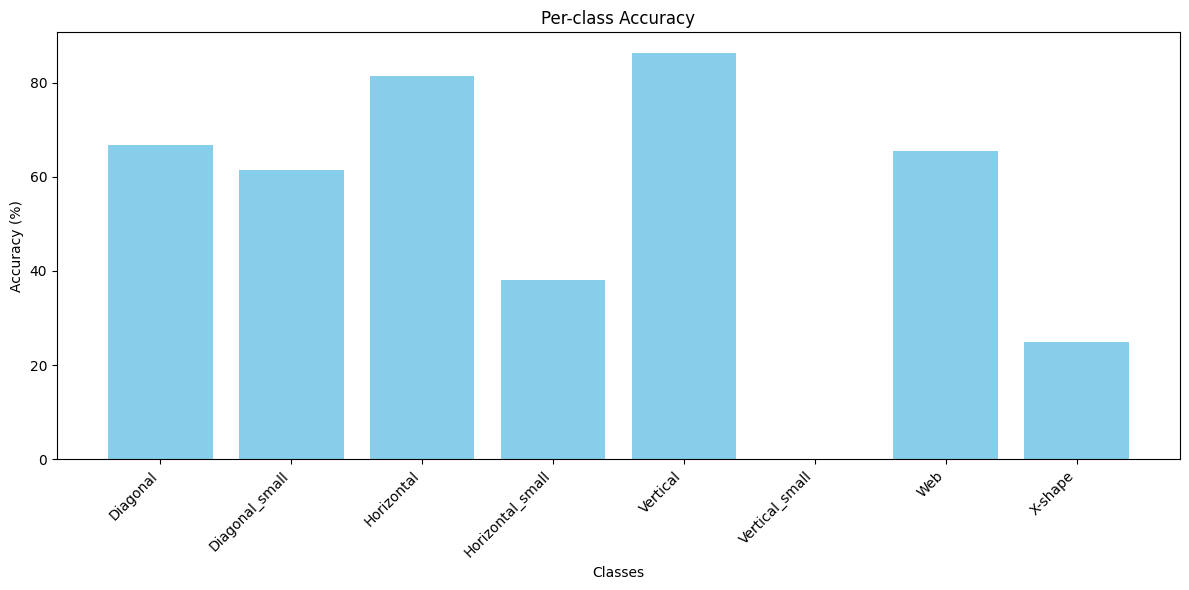

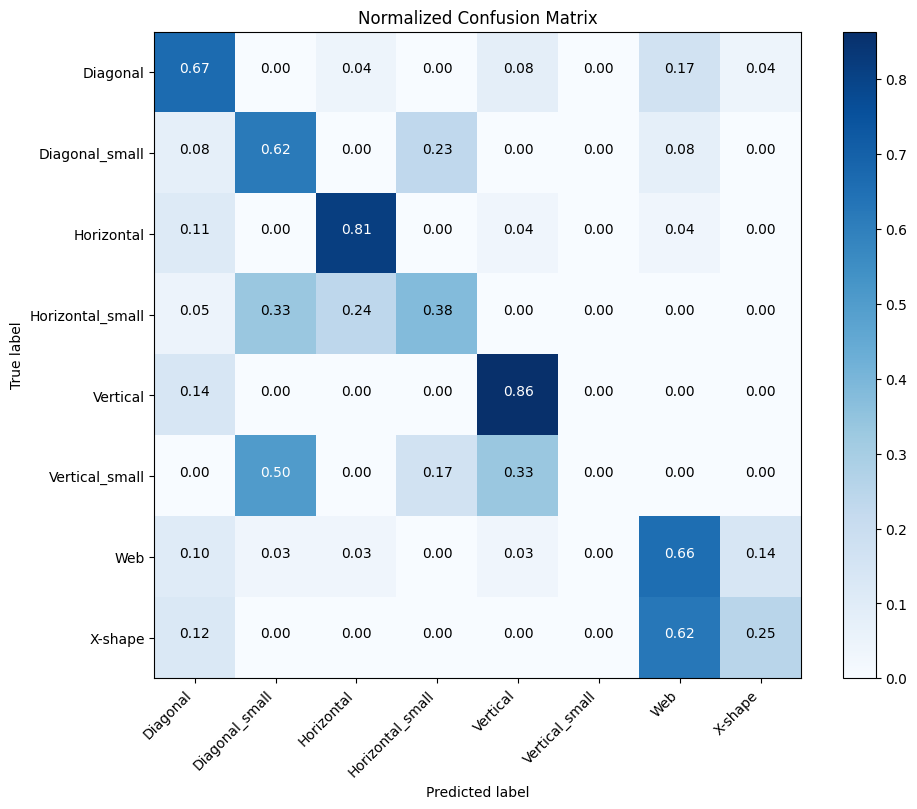

In [12]:
plot_evaluation_metrics(class_correct, class_total, confusion_matrix)

#### Generate prediction

In [6]:
import os
# Change this part to your path
test_folder_path="./test"        
csv_file_path="./submission_example.csv"
model_path="best_model.pth"
file_extension=".jpg"           


# Load CSV file
df = pd.read_csv(csv_file_path)
print(f"Loaded CSV with {len(df)} entries")

# Get column names
columns = df.columns.tolist()
first_col = columns[0]  # Image name column
second_col = columns[1]  # Empty column for predictions

# Load model
model_.load_state_dict(torch.load(model_path, map_location=device))
# model_ = trained_model
model_.to(device)
model_.eval()

imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

# Set up transformation (same as we set up earlier in the dataloading part, put I put here again for clarity)
transform = transforms.Compose([
    transforms.CenterCrop((450, 270)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
])


for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        img_name = str(row[first_col]).strip()
        
        img_path = os.path.join(test_folder_path, img_name + file_extension)
               
        # Process the image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            output = model_(img_tensor)
            _, predicted = torch.max(output.data, 1)
            predicted_idx = predicted.item()
        
        # Update CSV
        df.at[idx, second_col] = classes[predicted_idx]
        
    except Exception as e:
        print(f"Error with image {img_name}: {e}")

# Save updated CSV
df.to_csv(csv_file_path, index=False)
print(f"Updated CSV saved to {csv_file_path}")

Loaded CSV with 100 entries


100%|██████████| 100/100 [00:00<00:00, 102.53it/s]

Updated CSV saved to ./submission_example.csv


c:\Users\almon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


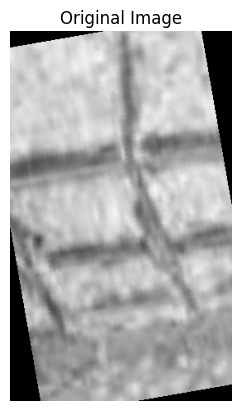

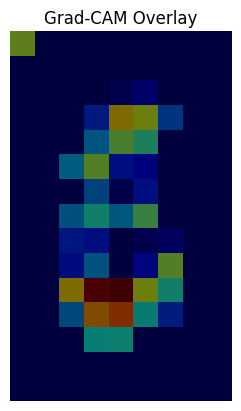

In [13]:
from torchvision.models.feature_extraction import create_feature_extractor
import torch.nn.functional as F

# Register hook containers
activations = None
gradients = None

# Hook functions
def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Hook into the last conv layer of ResNet
target_layer = model_.layer4[-1].conv2
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_backward_hook(backward_hook)

def generate_gradcam(img_tensor, label):
    global activations, gradients

    input_tensor = img_tensor.unsqueeze(0).to(device).requires_grad_()
    
    # Forward pass
    model_.eval()
    output = model_(input_tensor)
    class_idx = output.argmax(dim=1).item()

    # Backward pass
    model_.zero_grad()
    output[0, class_idx].backward()

    if gradients is None or activations is None:
        raise RuntimeError("Hooks did not capture gradients or activations.")

    # Compute weights and apply Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-6
    return heatmap

# Visualize Grad-CAM on random val image
inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

def show_gradcam(img_tensor, heatmap):
    img_tensor = inv_norm(img_tensor.cpu())
    img_np = np.transpose(img_tensor.numpy(), (1, 2, 0))
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    plt.show()

def show_original(img_tensor):
    img_tensor = inv_norm(img_tensor.cpu())
    img_np = np.transpose(img_tensor.numpy(), (1, 2, 0))
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

# Run on one image
val_transform = transforms.Compose([
        transforms.RandomResizedCrop((450, 270)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
    ])
full_dataset = torchvision.datasets.ImageFolder(root=path_dataset, transform=val_transform)
sample_img, label = random.choice(full_dataset)
heatmap = generate_gradcam(sample_img, label)
show_original(sample_img)
show_gradcam(sample_img, heatmap)